In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dataset
from torchvision.transforms import Resize, ToTensor, ToPILImage, Compose

from PIL import Image
import pickle
from gensim.models import KeyedVectors
import os
import re
import matplotlib.pyplot as plt
from IPython.display import display 
import numpy as np

from models import ImageEncoder, SentenceDecoder, WordDecoder

In [2]:
# parameters
img_size = 256
embedd_size = 256
hidden_size = 512
img_feature_size = (img_size // 32) ** 2

vocabulary = pickle.load(open('full_idxr-obj', 'rb'))
inv_vocab = {v: k for k, v in vocabulary.items()}
vocab_size = len(vocabulary)

word_vectors = KeyedVectors.load('glove256_vocab_full.kv', mmap='r').vectors


model_name = '5-4-1:00'

In [3]:
class DemoDataset(Dataset):
    def __init__(self, transform=[Resize((256, 256)), ToTensor()]):
        self.files = []
        self.transform = transform

        self.demo = '../demo_files/'
        self.files = []
        for file in os.listdir(self.demo + 'img'):
            self.files.append(file[:-4])

        self.vocabulary = pickle.load(open('full_idxr-obj', 'rb'))

        self.s_max = 8
        self.n_max = 18

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.demo + 'img/' + self.files[idx] +'.png'
        report_path = self.demo + 'label/' + self.files[idx] +'.txt'

        image_to_tensor = Compose(self.transform)
        img = image_to_tensor(Image.open(img_path).convert('RGB'))

        target = []
        longest_sentence_length = 0

        try:
            with open (report_path, "r") as r_file:
                file_read = r_file.read()
                report = re.split("[\n:]", file_read)
                for i in range(len(report)):
                    report[i] = report[i].strip().lower()

            try:
                index = report.index('findings')
            except ValueError:
                index = report.index('findings and impression')
            try:
                index2 = report.index('impression')
            except ValueError:
                index2 = len(report)

            sentences = ' '.join(report[index+2:index2]).split('. ')

            for i, sentence in enumerate(sentences):
                if len(target) >= self.s_max:
                    break
                sentence = sentence.lower().replace('.', '').replace(',', '').split()
                if len(sentence) == 0 or len(sentence) > self.n_max:
                    continue
                tokens = list()
                tokens.append(self.vocabulary['<start>'])
                tokens.extend([self.vocabulary[token] for token in sentence])
                tokens.append(self.vocabulary['<end>'])
                if longest_sentence_length < len(tokens):
                    longest_sentence_length = len(tokens)
                target.append(tokens)

        except ValueError:
            pass

        num_sentences = len(target)
        return (img, target, num_sentences, longest_sentence_length, img_path)
    
def collate_fn(data):
    pre_images, pre_captions, num_sentences, longest_sentence_length, pre_image_paths = zip(*data)
    # remove empty image-caption pairs
    images = []
    captions = []
    image_paths = []
    for i in range(len(pre_captions)):
        cap = pre_captions[i]
        if len(cap) > 0:
            images.append(pre_images[i])
            captions.append(pre_captions[i])
            image_paths.append(pre_image_paths[i])
    num_sentences = [len(cap) for cap in captions]

    try:
        images = torch.stack(images, 0)
    except RuntimeError: #if the batch ends up being fully corrupt
        images = torch.tensor(images)
    try:
        max_sentence_num = max(num_sentences)
    except ValueError:
        max_sentence_num = 0
    max_word_num = max(longest_sentence_length)

    targets = np.zeros((len(captions), max_sentence_num, max_word_num))
    word_lengths = np.zeros((len(captions), max_sentence_num))
    prob = np.zeros((len(captions), max_sentence_num))

    for i, caption in enumerate(captions):
        for j, sentence in enumerate(caption):
            targets[i, j, :len(sentence)] = sentence[:]
            word_lengths[i, j] = len(sentence)
            prob[i, j] = 1

    targets = torch.Tensor(targets).long()
    prob = torch.Tensor(prob)

    return images, targets, num_sentences, word_lengths, prob, image_paths

In [4]:
dataset = DemoDataset(transform=[Resize((img_size, img_size)), ToTensor()])
loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

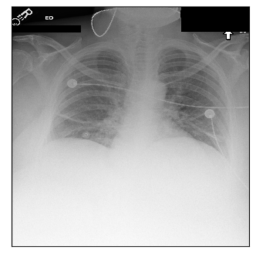

<start> portable upright image of the chest <end> <start> lung volumes are low with associated bronchovascular crowding <end> <start> in addition there are increased interstitial markings and perihilar fullness consistent with mild pulmonary edema <end> <start> there is no pleural effusion or pneumothorax <end> <start> the cardiomediastinal silhouette is unremarkable <end> <start> no free air is seen under the diaphragm <end>


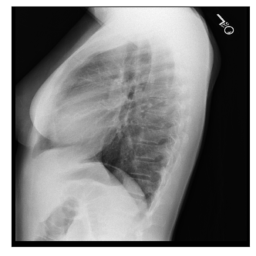

<start> frontal and lateral chest radiograph demonstrate well expanded and clear lungs <end> <start> there is no focal consolidation <end> <start> the cardiac and hilar contours are unremarkable <end> <start> there is no pleural effusion or pneumothorax <end>


In [5]:
for idx, (img, report, num_sentences, word_lengths, prob, image_paths) in enumerate(loader):
    to_image = ToPILImage()
    display(to_image(img[0]))
    print(' '.join([' '.join([inv_vocab[word_i.item()] for word_i in sentence if word_i != 0]) for sentence in report[0]]))

In [6]:
def get_models():
    img_enc = ImageEncoder(embedd_size, hidden_size, img_size)
    sentence_dec = SentenceDecoder(hidden_size)
    word_dec = WordDecoder(vocab_size, hidden_size, img_feature_size, word_vectors)
    
    return img_enc, sentence_dec, word_dec

In [7]:
def test():
    img_enc, sentence_dec, word_dec = get_models()
    model_dict = torch.load('save/{model}.pth'.format(model=model_name), map_location='cpu')
    img_enc.load_state_dict(model_dict['encoder_state_dict'])
    sentence_dec.load_state_dict(model_dict['sentence_decoder_state_dict'])
    word_dec.load_state_dict(model_dict['word_decoder_state_dict'])

    for idx, (images, reports, num_sentences, word_lengths, prob, image_paths) in enumerate(loader):
        img_enc.eval()
        sentence_dec.eval()
        word_dec.eval()

        if len(images) == 0:
            continue
        
        with torch.no_grad():
            img_features, img_avg_features = img_enc(images)
            sentence_states = None

            pred_reports = [[]]
            s_max = 8
            n_max = 18
            generate = True
            sentence_idx = 0
            while generate:
                stop, topic, sentence_states = sentence_dec(img_avg_features, sentence_states)
                word_input = torch.tensor(vocabulary['<start>']).unsqueeze(0)
                sentence = [word_input.item()]
                
                h_z = torch.zeros(1, hidden_size) 
                c_z = torch.zeros(1, hidden_size)
                wStates = (h_z, c_z)
                
                word_idx = 0
                make_words = True
                while make_words:
                    scores, wStates = word_dec(img_features, img_avg_features, topic, word_input, wStates)
                    word_input = torch.argmax(scores, dim=1)
                    sentence.append(word_input.item())
                    make_words = sentence[-1] != vocabulary['<end>']
                    if make_words and word_idx >= word_lengths[0][sentence_idx]:
                        break
                    word_idx += 1
                pred_reports[0].append(sentence)
                generate = not (stop > 0.5).squeeze()[1].item()
                if generate and sentence_idx >= num_sentences[0] - 1:
                    break
                sentence_idx += 1


            print("Predicted:", ' '.join([' '.join([inv_vocab[word_i] for word_i in sentence]) \
                                     for sentence in pred_reports[0]]))
            print("Ground Truth:", ' '.join([' '.join([inv_vocab[word_i.item()] for word_i in sentence \
                                                       if word_i != 0]) for sentence in reports[0]]))
    

In [ ]:
test()

here
here
1
2
3
4
